## Milestone 2:
Here's your guidance on milestone 2. The big picture is as follows: now that you understand how to make networks and measure centrality, let's shift into predicting centrality using machine learning.

The question is: given all the other centrality measures that I already have on a node, can I predict its centrality? E.g. given degree and betwenness centrality, can I predict closeness? Note that centralities are rankings. So you're only dealing with integers (rank 1, rank 2, rank 3...).
Here is the methodology to answer this question:
- for each type of network (random, SF, SM), create 100 instances equally split in networks of 100 nodes, 200 nodes, 400 nodes, and 800 nodes. (So you'd have 25 SF networks with 100 nodes for instance). In each instance, compute at least five different centrality measures for each node, and turn them into rankings. The result should go into a data.csv file, with headers such as

|networkType|networkSize|instanceNumber|nodeNumber|degree rank|closeness rank|betweenness rank|...|
|-----------|-----------|--------------|----------|-----------|--------------|-------------------|---|
|scale-free | 100| 1| 1| 6| 2| 20| ...|
|scale-free | 100| 1| 2| 5| 3| 21| ...|
|scale-free | 100| 1| 4| 10| 4| 19| ...|
    
    
(The above shows three nodes from one instance of a scale-free graph of size 100)

- compute the pairwise correlations between the rankings across all network types, as well as within each network type (random, SF, SM). We want this as a 'baseline'. The idea is that we should be able to make accurate predictions even where there didn't appear to be a linear correlation.
- we'll use machine learning algorithms for predictions. The logic is that we first try to make coarse predictions. If it doesn't work (=inaccurate) then we get even more coarse. If it works, we can try to be more precise. In other words, we don't start shooting for the moon but we try to find a middle ground (think of it as a binary search). Our starting point will be to predict whether one centrality of a node is in the top 25% based on the other centrality. For instance, given the ranks in degree, closeness, etc., is the node's betweenness in the top 25% or not (yes/no)? This is a binary classification. The steps would be to create the class outcome columns (data preparation). Then, for each prediction, ensure that the original centrality is removed (e.g. if you predict top 25% degree then you should not be using degree rank!), balance the data (so we have 50-50 of yes/no), and predict. I recommend using at least three different algorithms (e.g., decision trees, support vector machine, random forests; see textbook chapters on the last two) and a ten-fold cross-validation (also shown in the textbook). Balancing and cross-validation will be discussed in the upcoming Tuesday class. We'd like results (=accuracy) to be presented overall as well as divided per network type (so that we can see e.g. if we're better at making predictions in small-world than in random networks).

This milestone also comes with a bonus of 10% of your milestone 2 grade. That is, if you achieve the bonus in its entirety, whatever grade you got will be multiplied by 1.10. The bonus consists of doing all of the above on the forth type of network: small-world scale-free. Which means you need to be able to demonstrate that you can generate such networks for starters (fit of degree distribution / low average path length / high clustering). You can use google scholar to find a model that generates such networks, you do not need to invent them from scratch.

## Part 1: Data Generation

The five centralities that we will examine first are degree centrality, closeness centrality, betweeness centrality, load flow centrality, and reaching centrality. All of the data for all of the graphs will be loaded into data.csv.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

In [2]:
def get_degrees(G):
    deg = nx.degree_centrality(G)
    deg_df = pd.Series(deg).to_frame()
    deg_df.columns = ['Degree']
    deg_df['degree_rank'] = deg_df['Degree'].rank(method = 'min', ascending = False)
    return deg_df

In [3]:
def get_closeness(G):
    deg = nx.degree_centrality(G)
    deg_df = pd.Series(deg).to_frame()
    deg_df.columns = ['Closeness']
    deg_df['closeness_rank'] = deg_df['Closeness'].rank(method = 'min', ascending = False)
    return deg_df

In [4]:
def get_betweeness(G):
    deg = nx.betweenness_centrality(G)
    deg_df = pd.Series(deg).to_frame()
    deg_df.columns = ['Betweeness']
    deg_df['betweeness_rank'] = deg_df['Betweeness'].rank(method = 'min', ascending = False)
    return deg_df

In [5]:
def get_current_flow(G):
    deg = nx.load_centrality(G)
    deg_df = pd.Series(deg).to_frame()
    deg_df.columns = ['Load']
    deg_df['load_rank'] = deg_df['Load'].rank(method = 'min', ascending = False)
    return deg_df

In [6]:
def get_global_reaching(G):
    deg = nx.load_centrality(G)
    deg_df = pd.Series(deg).to_frame()
    deg_df.columns = ['Reaching']
    deg_df['reach_rank'] = deg_df['Reaching'].rank(method = 'min', ascending = False)
    return deg_df

Networks and Parameters:

|Network Types | Parameter(s) |
|--------------|--------------|
|scale-free| {size : How many nodes to generate} |
|small-world | {size : How many nodes to generate, k : k nearest neighbor in a ring, p : probability of rewiring each edge}|
|random | {size : How many nodes to generate, n : number of edges}|
|scale-free & small-world |{size : How many nodes to generate, m : number of random edges for each node, p : probability of rewiring each edge} |

In [7]:
with open('data.csv', 'w') as wr:
    # Write the column headers to csv
    wr.write('networkType,networkSize,instanceNumber,nodeNumber,degreeRank,closenessRank,betweennessRank,loadRank,reachRank\n')
    networkTypes = ['scale-free', 'small-world', 'random', 'small-world/scale-free'] # networks to add
    sizes = [100, 200, 400, 800] # Sizes to add
    G = nx.scale_free_graph(100) # Initialization of the graph so the scope of the variable is outside the loops
    
    for netType in networkTypes: # for each network type
        for size in sizes:
            for instNum in range(1, 26): # generate 25 networks for each size and each network type
                if netType == 'scale-free':
                    G = nx.scale_free_graph(size)
                elif netType == 'small-world':
                    G = nx.watts_strogatz_graph(size, 3, 0.5)
                elif netType == 'small-world/scale-free':
                    G = nx.powerlaw_cluster_graph(size, 3, 0.5)
                else:
                    G = nx.gnm_random_graph(size, size * 4)
                degree_list = get_degrees(G)
                closeness_list = get_closeness(G)
                betweeness_list = get_betweeness(G)
                load_list = get_current_flow(G)
                reach_list = get_global_reaching(G)
                for node in G.nodes(): # record network properties in csv file
                    wr.write(netType + ', ' + str(size)+ ', ' + str(instNum) + ', ')
                    wr.write(str(node) + ', ' + str(degree_list['degree_rank'][node]) + ', ')
                    wr.write(str(closeness_list['closeness_rank'][node]) + ', ')
                    wr.write(str(betweeness_list['betweeness_rank'][node]) + ', ')
                    wr.write(str(load_list['load_rank'][node]) + ', ')
                    wr.write(str(reach_list['reach_rank'][node]) + '\n')
                    

In milestone 1, we failed to correctly generate a network that had both the properties of a scale-free & small-world network. After doing research, we came across this research paper: https://www.uvm.edu/pdodds/files/papers/others/2002/holme2002a.pdf . These researchers were able to generate a network that had both of the network properties. Networkx has a function implemented that will generate a random graph with this algorithm and it is demonstrated below.

In [2]:
G = nx.powerlaw_cluster_graph(100, 3, 0.5)

/Users/Alex/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


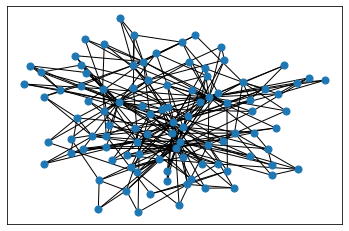

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=False, node_size=50)

## Part 2: Centrality Correlations

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

data = pd.read_csv("data.csv")
RND = data.loc[data['networkType'] == 'random']
SF = data.loc[data['networkType'] == 'scale-free']
SW = data.loc[data['networkType'] == 'small-world']
SFSW = data.loc[data['networkType'] == 'small-world/scale-free']

In [2]:
allP = data.corr(method ='pearson')
allS = data.corr(method='spearman')
allK = data.corr(method ='kendall')

rndP = RND.corr(method ='pearson')
rndS = RND.corr(method ='spearman')
rndK = RND.corr(method ='kendall')

sfP = SF.corr(method='pearson')
sfS = SF.corr(method='spearman')
sfK = SF.corr(method='kendall')

swP = SW.corr(method='pearson')
swS = SW.corr(method='spearman')
swK = SW.corr(method='kendall')

sfswP = SFSW.corr(method='pearson')
sfswS = SFSW.corr(method='spearman')
sfswK = SFSW.corr(method='kendall')

In [3]:
allP.to_csv('pairwise/all-pearson.csv')
allS.to_csv('pairwise/all-spearman.csv')
allK.to_csv('pairwise/all-kendall.csv')

rndP.to_csv('pairwise/rnd-pearson.csv')
rndS.to_csv('pairwise/rnd-spearman.csv')
rndK.to_csv('pairwise/rnd-kendall.csv')

sfP.to_csv('pairwise/sf-pearson.csv')
sfS.to_csv('pairwise/sf-spearman.csv')
sfK.to_csv('pairwise/sf-kendall.csv')

swP.to_csv('pairwise/sw-pearson.csv')
swS.to_csv('pairwise/sw-spearman.csv')
swK.to_csv('pairwise/sw-kendall.csv')

In [4]:
sfswP.to_csv('pairwise/sfsw-pearson.csv')
sfswS.to_csv('pairwise/sfsw-spearman.csv')
sfswK.to_csv('pairwise/sfsw-kendall.csv')

## Part 3: Model Generation

In [1]:
import pandas as pd
df = pd.read_csv('data.csv')

In [2]:
df.tail()

,networkType,networkSize,instanceNumber,nodeNumber,degreeRank,closenessRank,betweennessRank,loadRank,reachRank
149995,small-world/scale-free,800,25,795,478.0,478.0,639.0,660.0,660.0
149996,small-world/scale-free,800,25,796,478.0,478.0,591.0,602.0,602.0
149997,small-world/scale-free,800,25,797,478.0,478.0,487.0,497.0,497.0
149998,small-world/scale-free,800,25,798,478.0,478.0,439.0,474.0,474.0
149999,small-world/scale-free,800,25,799,478.0,478.0,462.0,492.0,492.0


### Create Class Outcome Columns:

In [3]:
degreeBinary = [] # create empty lists for adding binary values to dataframe
closenessBinary = []
betweennessBinary = []
loadBinary = []
reachBinary = []

for index, row in df.iterrows(): # iterate through all rows of dataframe
    if int(row['degreeRank']) <= int(row['networkSize']) / 4: 
        degreeBinary.append(1) # if the rank is in the top 25%, append 1 to binary list
    else:
        degreeBinary.append(0) # else, append a 0
        
    if int(row['closenessRank']) <= int(row['networkSize']) / 4:
        closenessBinary.append(1)
    else:
        closenessBinary.append(0)
        
    if int(row['betweennessRank']) <= int(row['networkSize']) / 4:
        betweennessBinary.append(1)
    else:
        betweennessBinary.append(0)
        
    if int(row['loadRank']) <= int(row['networkSize']) / 4:
        loadBinary.append(1)
    else:
        loadBinary.append(0)
        
    if int(row['reachRank']) <= int(row['networkSize']) / 4:
        reachBinary.append(1)
    else:
        reachBinary.append(0)
        
df['degreeBinary'] = degreeBinary # append binary lists as columns to the end of the dataframe
df['closenessBinary'] = closenessBinary
df['betweennessBinary'] = betweennessBinary
df['loadBinary'] = loadBinary
df['reachBinary'] = reachBinary

In [4]:
scale_free = df.loc[df['networkType'] == 'scale-free'] # add these new fields to the dataframe
small_world = df.loc[df['networkType'] == 'small-world']
random_data = df.loc[df['networkType'] == 'random']
small_world_scale_free = df.loc[df['networkType'] == 'small-world/scale-free']

### Random Forest Classifier:

In [5]:
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# balance data and train models
networkTypes = [scale_free, small_world, random_data, small_world_scale_free]
networkNames = ['Scale-Free', 'Small-World', 'Random', 'Small-World/Scale-Free']
nameIndex = -1
centralityTargets = ['degree', 'closeness']
# We don't train models on reach,load,betweenness because all of them have nodes with ranks tied < 25%

for df in networkTypes:
    nameIndex += 1
    for target in centralityTargets:
        print('\n\n\n' + networkNames[nameIndex] + ' predicting ' + target + ':')
        # first, drop unneeded columns and the ranking of our target
        temp = df.copy().drop(['networkType', 'instanceNumber', 'nodeNumber', target + 'Rank','betweennessBinary','loadBinary','reachBinary'],axis=1)
        # then, drop all binary columns except for our target
        temp = temp.drop([x + 'Binary' for x in centralityTargets if x != target], axis=1)
        
        # balance the data
        num_zeros = temp[target + 'Binary'].value_counts()[0]
        num_ones = temp[target + 'Binary'].value_counts()[1]
        if num_zeros > num_ones: 
            # if num_ones is the minority, remove zeros to equal size
            # chop down zeros to size: num_ones
            chopping_block = random.sample(range(0, num_zeros), num_zeros - num_ones)
            temp = temp.drop(temp.index[chopping_block])

        else: 
            # if num_zeros is the minority, remove ones to equal size
            # chop down ones to size: num_zeros
            chopping_block = random.sample(range(0, num_ones), num_ones - num_zeros)
            temp = temp.drop(temp.index[chopping_block])
        
        # divide data into training and testing sets
        temp_train, temp_test = train_test_split(temp, test_size = 0.2, random_state = 0)
        
        # then, divide training data into 10 training and validation folds
        sum = 0
        folds = 10
        kf = KFold(n_splits=folds)
        for train, test in kf.split(temp_train):
            X_train = temp_train.iloc[train, 0:5].values
            y_train = temp_train.iloc[train, 5].values
            X_test = temp_train.iloc[test, 0:5].values
            y_test = temp_train.iloc[test, 5].values
            
            classifier = RandomForestClassifier(n_estimators=20, random_state=0)
            classifier.fit(X_train, y_train)
            pred = classifier.predict(X_test)
            sum += accuracy_score(pred, y_test)
        print('\nAverage accuracy from ' + str(folds) + ' folds: ' + str(sum / folds))
        
        # then, train a model with all of the training data and test against the test data
        X_train = temp_train.iloc[:, 0:5].values
        y_train = temp_train.iloc[:, 5].values
        X_test = temp_test.iloc[:, 0:5].values
        y_test = temp_test.iloc[:, 5].values
    
        classifier = RandomForestClassifier(n_estimators=20, random_state=0)
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)
        
        print(classification_report(prediction, y_test))
        print('Total Accuracy: ' + str(accuracy_score(prediction, y_test)))
        print('Example: The prediction of '+target+' based on the rank of other attributes as 100,26,8,8,8 is '+str(classifier.predict([[800,26,8,8,8]])))
        




Scale-Free predicting degree:

Average accuracy from 10 folds: 0.999780310299256
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3165
           1       1.00      1.00      1.00      1387

    accuracy                           1.00      4552
   macro avg       1.00      1.00      1.00      4552
weighted avg       1.00      1.00      1.00      4552

Total Accuracy: 0.999780316344464
Example: The prediction of degree based on the rank of other attributes as 100,26,8,8,8 is [1]



Scale-Free predicting closeness:

Average accuracy from 10 folds: 0.9998901400631219
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3133
           1       1.00      1.00      1.00      1419

    accuracy                           1.00      4552
   macro avg       1.00      1.00      1.00      4552
weighted avg       1.00      1.00      1.00      4552

Total Accuracy: 1.0
Example: The prediction o

### Decision Tree Classifier:

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

nameIndex = -1
for df in networkTypes:
    nameIndex += 1
    for target in centralityTargets:
        print('\n\n\n' + networkNames[nameIndex] + ' predicting ' + target + ':')
        # first, drop unneeded columns and the ranking of our target
        temp = df.copy().drop(['networkType', 'instanceNumber', 'nodeNumber', target + 'Rank','betweennessBinary','loadBinary','reachBinary'],axis=1)
        # then, drop all binary columns except for our target
        temp = temp.drop([x + 'Binary' for x in centralityTargets if x != target], axis=1)
        
        # balance the data
        num_zeros = temp[target + 'Binary'].value_counts()[0]
        num_ones = temp[target + 'Binary'].value_counts()[1]
        if num_zeros > num_ones: 
            # if num_ones is the minority, remove zeros to equal size
            # chop down zeros to size: num_ones
            chopping_block = random.sample(range(0, num_zeros), num_zeros - num_ones)
            temp = temp.drop(temp.index[chopping_block])

        else: 
            # if num_zeros is the minority, remove ones to equal size
            # chop down ones to size: num_zeros
            chopping_block = random.sample(range(0, num_ones), num_ones - num_zeros)
            temp = temp.drop(temp.index[chopping_block])
        
        # divide data into training and testing sets
        temp_train, temp_test = train_test_split(temp, test_size = 0.2, random_state = 0)
        
        # then, divide training data into 10 training and validation folds
        sum = 0
        folds = 10
        kf = KFold(n_splits=folds)
        for train, test in kf.split(temp_train):
            X_train = temp_train.iloc[train, 0:5].values
            y_train = temp_train.iloc[train, 5].values
            X_test = temp_train.iloc[test, 0:5].values
            y_test = temp_train.iloc[test, 5].values
            
            classifier = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
            classifier.fit(X_train, y_train)
            pred = classifier.predict(X_test)
            sum += accuracy_score(pred, y_test)
        print('\nAverage accuracy from ' + str(folds) + ' folds: ' + str(sum / folds))
        
        # then, train a model with all of the training data and test against the test data
        X_train = temp_train.iloc[:, 0:5].values
        y_train = temp_train.iloc[:, 5].values
        X_test = temp_test.iloc[:, 0:5].values
        y_test = temp_test.iloc[:, 5].values
    
        classifier = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)
        
        print(classification_report(prediction, y_test))
        print('Total Accuracy: ' + str(accuracy_score(prediction, y_test)))
        print('Example: The prediction of '+target+' based on the rank of other attributes as 100,26,8,8,8 is '+str(classifier.predict([[800,26,8,8,8]])))




Scale-Free predicting degree:

Average accuracy from 10 folds: 0.9461715577119202
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      3320
           1       0.87      0.97      0.91      1232

    accuracy                           0.95      4552
   macro avg       0.93      0.95      0.94      4552
weighted avg       0.95      0.95      0.95      4552

Total Accuracy: 0.9503514938488576
Example: The prediction of degree based on the rank of other attributes as 100,26,8,8,8 is [1]



Scale-Free predicting closeness:

Average accuracy from 10 folds: 0.9499609561224058
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2979
           1       0.99      0.86      0.92      1573

    accuracy                           0.95      4552
   macro avg       0.96      0.93      0.94      4552
weighted avg       0.95      0.95      0.95      4552

Total Accuracy: 0.9481546572934973
Example:

### Support Vector Classifier:

In [7]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

nameIndex = -1
for df in networkTypes:
    nameIndex += 1
    for target in centralityTargets:
        print('\n\n\n' + networkNames[nameIndex] + ' predicting ' + target + ':')
        # first, drop unneeded columns and the ranking of our target
        temp = df.copy().drop(['networkType', 'instanceNumber', 'nodeNumber', target + 'Rank','betweennessBinary','loadBinary','reachBinary'],axis=1)
        # then, drop all binary columns except for our target
        temp = temp.drop([x + 'Binary' for x in centralityTargets if x != target], axis=1)
        
        # balance the data
        num_zeros = temp[target + 'Binary'].value_counts()[0]
        num_ones = temp[target + 'Binary'].value_counts()[1]
        if num_zeros > num_ones: 
            # if num_ones is the minority, remove zeros to equal size
            # chop down zeros to size: num_ones
            chopping_block = random.sample(range(0, num_zeros), num_zeros - num_ones)
            temp = temp.drop(temp.index[chopping_block])

        else: 
            # if num_zeros is the minority, remove ones to equal size
            # chop down ones to size: num_zeros
            chopping_block = random.sample(range(0, num_ones), num_ones - num_zeros)
            temp = temp.drop(temp.index[chopping_block])
        
        # divide data into training and testing sets
        temp_train, temp_test = train_test_split(temp, test_size = 0.2, random_state = 0)
        
        # then, divide training data into 10 training and validation folds
        sum = 0
        folds = 10
        kf = KFold(n_splits=folds)
        for train, test in kf.split(temp_train):
            X_train = temp_train.iloc[train, 0:5].values
            y_train = temp_train.iloc[train, 5].values
            X_test = temp_train.iloc[test, 0:5].values
            y_test = temp_train.iloc[test, 5].values
            
            classifier = SVC(kernel='linear')
            classifier.fit(X_train, y_train)
            pred = classifier.predict(X_test)
            sum += accuracy_score(pred, y_test)
        print('\nAverage accuracy from ' + str(folds) + ' folds: ' + str(sum / folds))
        
        # then, train a model with all of the training data and test against the test data
        X_train = temp_train.iloc[:, 0:5].values
        y_train = temp_train.iloc[:, 5].values
        X_test = temp_test.iloc[:, 0:5].values
        y_test = temp_test.iloc[:, 5].values
    
        classifier = SVC(kernel='linear')
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)
        
        print(classification_report(prediction, y_test))
        print('Total Accuracy: ' + str(accuracy_score(prediction, y_test)))
        print('Example: The prediction of '+target+' based on the rank of other attributes as 100,26,8,8,8 is '+str(classifier.predict([[800,26,8,8,8]])))
    




Scale-Free predicting degree:

Average accuracy from 10 folds: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3191
           1       1.00      1.00      1.00      1361

    accuracy                           1.00      4552
   macro avg       1.00      1.00      1.00      4552
weighted avg       1.00      1.00      1.00      4552

Total Accuracy: 1.0
Example: The prediction of degree based on the rank of other attributes as 100,26,8,8,8 is [1]



Scale-Free predicting closeness:

Average accuracy from 10 folds: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3176
           1       1.00      1.00      1.00      1376

    accuracy                           1.00      4552
   macro avg       1.00      1.00      1.00      4552
weighted avg       1.00      1.00      1.00      4552

Total Accuracy: 1.0
Example: The prediction of closeness based on the rank of other attr